In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score,confusion_matrix, plot_confusion_matrix, plot_roc_curve, recall_score, f1_score, precision_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from copy import deepcopy

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as iPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, plot_confusion_matrix, plot_roc_curve, recall_score, f1_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb


In [2]:
df = pd.read_parquet('./Data/draft0522.parquet')

In [3]:
model_df = df.drop(['school_name'],axis=1)

In [4]:
model_df.Round[model_df.Round <= 3] = 2

C:\Users\capta\AppData\Local\Temp\ipykernel_4748\2943970229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.Round[model_df.Round <= 3] = 2


In [5]:
model_df.Round[model_df.Round == 8] = 0

C:\Users\capta\AppData\Local\Temp\ipykernel_4748\3023946570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.Round[model_df.Round == 8] = 0


In [6]:
model_df.Round[model_df.Round >=4] = 1

C:\Users\capta\AppData\Local\Temp\ipykernel_4748\4119251177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.Round[model_df.Round >=4] = 1


In [7]:
model_df.Round.value_counts(normalize=True)

0.0    0.358002
1.0    0.349761
2.0    0.292237
Name: Round, dtype: float64

In [8]:
X = model_df.drop(['Round'],axis=1)
y = model_df.Round

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player
player_pick = X_test.pick
player_year = X_test.year
player_team = X_test.team
player_age = X_test.Age

X_train.drop(['player','pick','year','team','Age'],axis=1,inplace=True)
X_test.drop(['player','pick','year','team','Age'],axis=1,inplace=True)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player
player_pick = X_test.pick
player_year = X_test.year
player_team = X_test.team
player_age = X_test.Age

X_train.drop(['player','pick','year','team','Age'],axis=1,inplace=True)
X_test.drop(['player','pick','year','team','Age'],axis=1,inplace=True)

X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes('float64')

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[
    ('ss',StandardScaler()),
    ('impute',SimpleImputer(strategy='constant'))])

transformer = ColumnTransformer(transformers=[
    ('num', num_transformer, X_train_num.columns),
    ('cat', cat_transformer, X_train_cat.columns)])

pipe = Pipeline(steps=[
    ('trans',transformer),
    ('gaus',GaussianMixture(random_state=42))])

grid = {'gaus__n_components':[4,5]}

gridsearch = GridSearchCV(estimator=pipe,
                         param_grid=grid,
                         cv=5)

gridsearch.fit(X_train,y_train)

trans_train = gridsearch.predict(X_train)
trans_test = gridsearch.predict(X_test)
rfc = RandomForestClassifier(random_state=42)
rfc.fit(trans_train.reshape(-1,1),y_train)
y_preds = rfc.predict(trans_test.reshape(-1,1))

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

              precision    recall  f1-score   support

         0.0       0.35      0.59      0.44       717
         1.0       0.36      0.28      0.31       695
         2.0       0.34      0.15      0.21       591

    accuracy                           0.35      2003
   macro avg       0.35      0.34      0.32      2003
weighted avg       0.35      0.35      0.33      2003



C:\Users\capta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


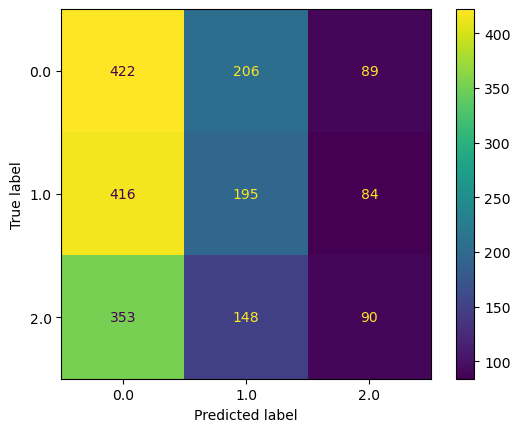

In [28]:
print(classification_report(y_test,y_preds))
plot_confusion_matrix(rfc,trans_test.reshape(-1,1),y_test)

In [13]:
preprocess = deepcopy(gridsearch.best_estimator_)
preprocess.steps.pop()
y_probs = pd.DataFrame(gridsearch.predict_proba(X_test))



C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [14]:
y_probs

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.92352259e-50],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [17]:
X_test

,pos,height,weight,forty_yd,vertical,bench_reps,broad_jump,cone,shuttle,g_season,...,tackles_total_career,tackles_loss_career,sacks_career,pass_defended_career,fumbles_forced_season,fumbles_forced_career,college_conference,speed,agility,alt_agility
2763,DT,75.0,313.0,5.06,26.5,30.0,101.0,NaN,NaN,NaN,...,107.0,13.5,5.0,3.0,NaN,2.0,None,95.493160,NaN,NaN
3758,RB,72.0,238.0,4.64,NaN,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,None,102.691626,NaN,NaN
1652,WR,74.0,188.0,4.52,40.0,NaN,122.0,7.03,4.43,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,None,90.081188,97.627673,108.223573
3872,WR,73.0,199.0,4.54,32.5,17.0,116.0,NaN,NaN,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,None,93.682756,NaN,NaN
5143,LB,75.0,241.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,...,289.0,24.5,14.5,1.0,2.0,6.0,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,S,71.0,203.0,4.45,36.5,20.0,121.0,7.28,4.30,12.0,...,89.0,12.0,1.5,NaN,NaN,NaN,None,103.534714,118.755084,105.228140
4714,S,72.0,209.0,4.63,34.5,17.0,114.0,7.45,4.30,13.0,...,190.0,14.0,1.0,13.0,NaN,NaN,None,90.960391,122.265087,101.089829
2622,WR,74.0,206.0,4.58,NaN,NaN,NaN,NaN,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Pacific Twelve Conference,93.634372,NaN,NaN
5693,TE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN


In [16]:
y_probs_df

,0,1,2,3
0,1.0,0.000000e+00,0.0,1.923523e-50
1,0.0,1.000000e+00,0.0,0.000000e+00
2,0.0,0.000000e+00,1.0,0.000000e+00
3,0.0,0.000000e+00,1.0,0.000000e+00
4,1.0,9.927473e-82,0.0,2.499562e-39
...,...,...,...,...
1998,0.0,1.000000e+00,0.0,0.000000e+00
1999,0.0,1.000000e+00,0.0,0.000000e+00
2000,0.0,0.000000e+00,1.0,0.000000e+00
2001,0.0,0.000000e+00,1.0,0.000000e+00


In [89]:
gridsearch.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler()),
                                                                  ('impute',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  Index(['height', 'weight', 'forty_yd', 'vertical', 'bench_reps', 'broad_jump',
       'cone', 'shuttle', 'g_season', 'def_int_season', 'def_int_yds_season',
       'def_int_yds_per_int_season', 'def_int_career', 'def_int_yds_...
       'tackles_loss_career', 'sacks_career', 'pass_defended_career',
       'fumbles_forced_season', 'fumbles_forced_career', 'speed', 'agility',
       'alt_agility'],
      dtype='object')),
                                                 ('cat',
                                             

In [91]:
X_transformed = preprocess.transform(X_train)

In [92]:
gridsearch.best_estimator_[-1].aic(X_transformed)

-3030368.4708298845

In [93]:
gridsearch.best_estimator_[-1].bic(X_transformed)

-2784792.57801094

In [94]:
y_pred = gridsearch.predict_proba(X_test)

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [95]:
y_pred_df = pd.DataFrame(y_pred)

In [96]:
from sklearn.manifold import TSNE

In [97]:
tsne = TSNE(random_state=42,learning_rate=100)
tsne_y_pred = tsne.fit_transform(y_pred_df)
tsne_y_pred = pd.DataFrame(tsne_y_pred, columns = ['TSNE1','TSNE2'])

C:\Users\capta\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [98]:
tsne_y_pred['group'] = np.argmax(y_pred_df.values, axis = 1)

In [99]:
tsne_x = transformer.fit_transform(X_test)
tsne_x = tsne.fit_transform(tsne_x)

C:\Users\capta\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [100]:
tsne_xs = pd.DataFrame(tsne_x, columns = ['TSNE1','TSNE2'])

In [101]:
x_tsne = pd.concat([tsne_xs,tsne_y_pred['group']],axis=1)

In [102]:
look = pd.concat([player_name.reset_index(),player_pick.reset_index(),player_team.reset_index(),player_year.reset_index(),y_test.reset_index(),X_test.reset_index(),tsne_y_pred.reset_index()],axis=1)

In [103]:
relook = pd.concat([player_name.reset_index(),player_pick.reset_index(),player_team.reset_index(),player_year.reset_index(),y_test.reset_index(),X_test.reset_index(),x_tsne.reset_index()],axis=1)

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

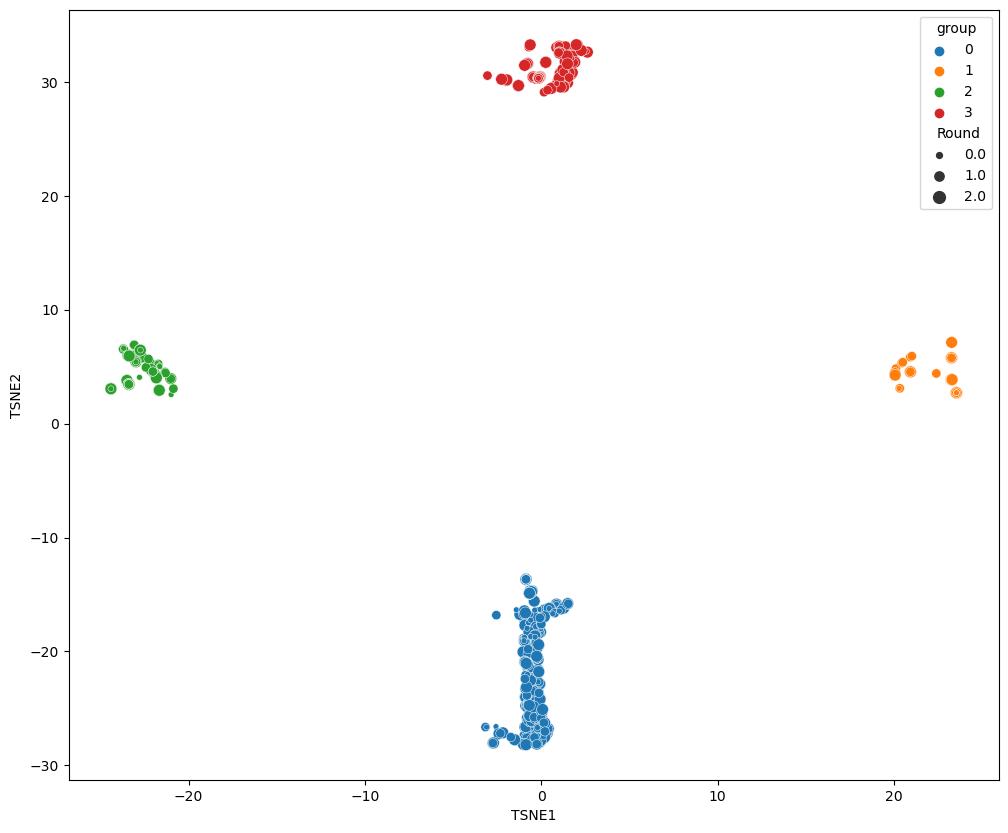

In [105]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=tsne_y_pred.TSNE1,y=tsne_y_pred.TSNE2, hue=tsne_y_pred['group'], palette = 'tab10',size=look.Round);

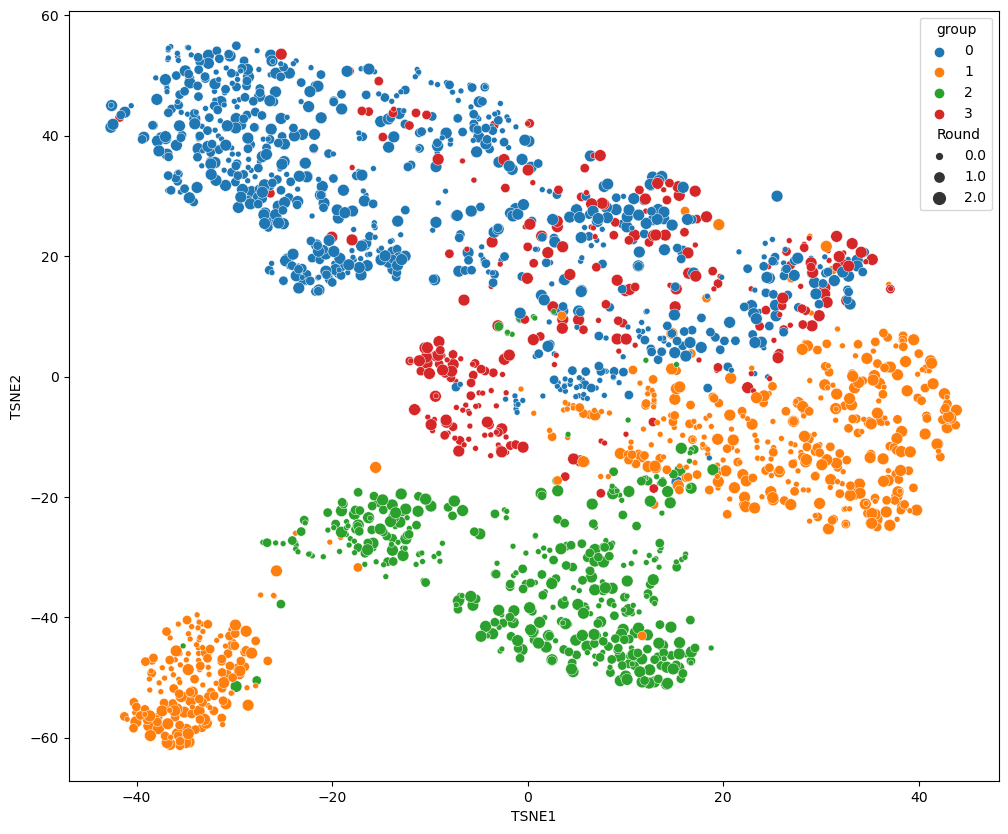

In [106]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=x_tsne.TSNE1,y=x_tsne.TSNE2, hue=x_tsne['group'], palette = 'tab10',size=look.Round);

In [30]:
relook.groupby('group').pos.value_counts()

group  pos 
0      OL      330
       LB      165
       DT      130
       DE       98
       DL       52
       LS        9
       QB        9
       TE        3
       CB        1
1      WR      292
       TE       98
       FB       23
2      QB       87
       LB       59
       P        36
       EDGE     22
       DE       14
       DT        7
       WR        6
       FB        3
       OL        2
       TE        2
       RB        1
3      CB      175
       RB      173
       S       144
       K        27
       DB       16
       LB       12
       WR        4
       LS        2
       QB        1
Name: pos, dtype: int64

In [31]:
clump2_l = relook[(relook.TSNE2 < 15) & (relook.group == 2) & (relook.TSNE1 < -8)]

In [32]:
clump2_l.pos.value_counts()

QB    77
P      7
WR     4
FB     1
Name: pos, dtype: int64

In [33]:
clump1_lt = relook[(relook.TSNE2 < -15) & (relook.TSNE2 > -32) & (relook.group == 1) & (relook.TSNE1 < -5)]

In [34]:
clump1_lt.pos.value_counts()

TE    80
FB    17
WR    14
Name: pos, dtype: int64

In [35]:
clump1_rb = relook[(relook.TSNE2 < -12) & (relook.group == 1) & (relook.TSNE1 >= -5)]

In [36]:
clump1_rb.pos.value_counts()

WR    267
TE      7
FB      3
Name: pos, dtype: int64

In [37]:
clump0_b = relook[(relook.TSNE2 < 15) & (relook.group == 0)]

In [38]:
clump0_b.pos.value_counts()

LB    131
DE     11
QB      8
LS      7
DL      3
TE      2
OL      2
DT      2
CB      1
Name: pos, dtype: int64

In [39]:
clump0_t = relook[(relook.TSNE2 >= 15) & (relook.group == 0)]

In [40]:
clump0_t.pos.value_counts()

OL    328
DT    128
DE     87
DL     49
LB     34
LS      2
TE      1
QB      1
Name: pos, dtype: int64

In [41]:
clump3_ml = relook[(relook.TSNE1 < -5) & (relook.TSNE2 > -20) & (relook.group == 3)]

In [42]:
clump3_ml.pos.value_counts()

K     14
DB     3
S      2
QB     1
Name: pos, dtype: int64

In [43]:
clump3_bl = relook[(relook.TSNE1 < -20) & (relook.group == 3)]

In [44]:
clump3_bl.pos.value_counts()

RB    159
CB      2
S       1
Name: pos, dtype: int64

In [45]:
clump3_r = relook[(relook.TSNE1 > -20) & (relook.group == 3)]

In [46]:
clump3_r.pos.value_counts()

CB    173
S     143
K      27
DB     16
RB     14
LB     12
WR      4
LS      2
QB      1
Name: pos, dtype: int64

In [47]:
clump3_bl.describe()

,index,index,pick,index,index,year,index,Round,index,height,...,fumbles_forced_season,fumbles_forced_career,Age,speed,agility,alt_agility,index,TSNE1,TSNE2,group
count,162.000000,162.000000,102.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,161.000000,...,0.0,0.0,98.000000,154.000000,96.000000,95.000000,162.000000,162.000000,162.000000,162.0
mean,2860.006173,2860.006173,124.009804,2860.006173,2860.006173,2013.222222,2860.006173,0.845679,2860.006173,70.416149,...,NaN,NaN,21.979592,100.873441,128.756079,122.110180,1020.648148,-35.133877,-47.989029,3.0
std,1780.215405,1780.215405,64.449458,1780.215405,1780.215405,5.355673,1780.215405,0.752396,1780.215405,1.671672,...,NaN,NaN,0.896495,9.408772,17.397139,11.241148,567.553806,4.429130,5.612877,0.0
min,12.000000,12.000000,3.000000,12.000000,12.000000,2005.000000,12.000000,0.000000,12.000000,66.000000,...,NaN,NaN,21.000000,74.975285,86.661659,97.723728,1.000000,-43.743515,-57.622452,3.0
25%,1332.250000,1332.250000,73.250000,1332.250000,1332.250000,2009.000000,1332.250000,0.000000,1332.250000,69.000000,...,NaN,NaN,21.000000,95.108379,117.736617,115.640822,508.500000,-38.678583,-52.279269,3.0
50%,2731.000000,2731.000000,122.000000,2731.000000,2731.000000,2013.000000,2731.000000,1.000000,2731.000000,71.000000,...,NaN,NaN,22.000000,101.038992,128.023540,121.726175,1050.500000,-35.214497,-48.119915,3.0
75%,4357.250000,4357.250000,173.750000,4357.250000,4357.250000,2018.000000,4357.250000,1.000000,4357.250000,72.000000,...,NaN,NaN,22.750000,106.306611,141.746213,129.459169,1517.500000,-32.046062,-44.068286,3.0
max,6051.000000,6051.000000,251.000000,6051.000000,6051.000000,2022.000000,6051.000000,2.000000,6051.000000,74.000000,...,NaN,NaN,25.000000,126.930219,177.551543,149.959963,1986.000000,-22.012407,-26.389200,3.0


In [48]:
pd.set_option("display.max_columns", None)
clump3_r.describe()

,index,index,pick,index,index,year,index,Round,index,height,weight,forty_yd,vertical,bench_reps,broad_jump,cone,shuttle,g_season,def_int_season,def_int_yds_season,def_int_yds_per_int_season,def_int_career,def_int_yds_career,def_int_yds_per_int_career,pass_cmp_season,pass_att_season,pass_cmp_pct_season,pass_yds_season,pass_yds_per_att_season,adj_pass_yds_per_att_season,pass_td_season,pass_int_season,pass_rating_season,pass_cmp_career,pass_att_career,pass_cmp_pct_career,pass_yds_career,pass_yds_per_att_career,adj_pass_yds_per_att_career,pass_td_career,pass_int_career,pass_rating_career,rush_att_season,rush_yds_season,rush_yds_per_att_season,rush_td_season,rec_season,rec_yds_season,rec_yds_per_rec_season,scrim_att_season,scrim_yds_season,scrim_yds_per_att_season,scrim_td_season,rush_att_career,rush_yds_career,rush_yds_per_att_career,rush_td_career,rec_career,rec_yds_career,rec_yds_per_rec_career,rec_td_career,scrim_att_career,scrim_yds_career,scrim_yds_per_att_career,scrim_td_career,fumbles_rec_yds_career,fumbles_rec_td_career,rec_td_season,def_int_td_season,def_int_td_career,fumbles_rec_career,fumbles_rec_yds_season,fumbles_rec_td_season,fumbles_rec_season,tackles_solo_season,tackles_assists_season,tackles_total_season,tackles_loss_season,sacks_season,pass_defended_season,tackles_solo_career,tackles_assists_career,tackles_total_career,tackles_loss_career,sacks_career,pass_defended_career,fumbles_forced_season,fumbles_forced_career,Age,speed,agility,alt_agility,index,TSNE1,TSNE2,group
count,392.000000,392.000000,244.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,389.000000,390.000000,360.000000,297.000000,290.000000,293.000000,209.000000,214.000000,307.000000,271.000000,222.000000,222.000000,304.000000,282.000000,282.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,3.000000,2.000000,1.0,3.000000,3.000000,3.000000,5.000000,4.000000,4.000000,4.000000,3.000000,3.000000,2.000000,2.000000,4.00000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,41.000000,53.000000,3.000000,71.000000,128.000000,115.000000,13.000000,18.0,61.000000,288.000000,286.000000,288.000000,261.000000,106.000000,173.000000,292.000000,292.000000,292.000000,287.000000,182.000000,213.000000,72.000000,150.000000,240.000000,358.000000,214.000000,208.000000,392.000000,392.000000,392.000000,392.0
mean,3045.380102,3045.380102,107.032787,3045.380102,3045.380102,2013.709184,3045.380102,0.918367,3045.380102,71.622108,200.882051,4.541444,35.715488,16.510345,121.385666,6.997081,4.199766,11.807818,2.708487,46.554054,18.256306,6.026316,92.024823,15.264894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.333333,38.333333,5.300000,3.0,34.333333,486.666667,11.666667,25.000000,393.750000,10.875000,3.250000,72.000000,452.333333,6.950000,9.000000,50.50000,715.750000,12.875000,5.250000,83.600000,1055.000000,10.375000,9.750000,36.585366,1.132075,3.333333,1.197183,1.468750,1.765217,34.769231,1.0,1.163934,38.986111,19.846154,58.694444,3.785441,1.660377,6.040462,101.085616,50.667808,151.753425,8.210801,2.543956,13.300469,1.458333,2.113333,22.320833,95.280752,130.691245,118.086190,1008.698980,21.771036,-10.994345,3.0
std,1798.411705,1798.411705,63.573157,1798.411705,1798.411705,5.396989,1798.411705,0.817625,1798.411705,1.807380,15.147312,0.147121,2.963864,4.480820,5.945362,0.211532,0.146664,2.103266,1.699641,41.182677,15.839784,3.424716,75.313268,10.707217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.214550,69.866539,7.778175,NaN,49.237520,760.111395,4.163332,39.849718,647.354295,2.970269,3.304038,110.869292,722.164340,0.777817,9.899495,64.52648,1019.523214,4.317696,5.439056,96.983504,1069.243658,3.993641,9.844626,25.106748,0.341813,4.041452,0.434896,0.802923,1.094888,23.367192,0.0,0.453884,14.972675,11.901530,24.478043,3.093408,1.479297,3.348652,44.965617,33.258375,73.437826,7.243757,3.441017,8.020837,0.767977,1.430899,0.882882,11.669283,20.480607,12.953791,5

In [49]:
look.groupby('group').mean()

C:\Users\capta\AppData\Local\Temp\ipykernel_18544\1321038469.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  look.groupby('group').mean()


,index,index,pick,index,index,year,index,Round,index,height,weight,forty_yd,vertical,bench_reps,broad_jump,cone,shuttle,g_season,def_int_season,def_int_yds_season,def_int_yds_per_int_season,def_int_career,def_int_yds_career,def_int_yds_per_int_career,pass_cmp_season,pass_att_season,pass_cmp_pct_season,pass_yds_season,pass_yds_per_att_season,adj_pass_yds_per_att_season,pass_td_season,pass_int_season,pass_rating_season,pass_cmp_career,pass_att_career,pass_cmp_pct_career,pass_yds_career,pass_yds_per_att_career,adj_pass_yds_per_att_career,pass_td_career,pass_int_career,pass_rating_career,rush_att_season,rush_yds_season,rush_yds_per_att_season,rush_td_season,rec_season,rec_yds_season,rec_yds_per_rec_season,scrim_att_season,scrim_yds_season,scrim_yds_per_att_season,scrim_td_season,rush_att_career,rush_yds_career,rush_yds_per_att_career,rush_td_career,rec_career,rec_yds_career,rec_yds_per_rec_career,rec_td_career,scrim_att_career,scrim_yds_career,scrim_yds_per_att_career,scrim_td_career,fumbles_rec_yds_career,fumbles_rec_td_career,rec_td_season,def_int_td_season,def_int_td_career,fumbles_rec_career,fumbles_rec_yds_season,fumbles_rec_td_season,fumbles_rec_season,tackles_solo_season,tackles_assists_season,tackles_total_season,tackles_loss_season,sacks_season,pass_defended_season,tackles_solo_career,tackles_assists_career,tackles_total_career,tackles_loss_career,sacks_career,pass_defended_career,fumbles_forced_season,fumbles_forced_career,Age,speed,agility,alt_agility,index,TSNE1,TSNE2
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2989.549561,2989.549561,114.591497,2989.549561,2989.549561,2013.549561,2989.549561,1.001255,2989.549561,75.505675,287.857683,5.033537,30.056311,24.707237,108.471545,7.566149,4.593736,11.389610,1.414894,19.134328,13.279104,1.768786,19.721805,11.097744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.361702,1.000000,NaN,NaN,NaN,1.891304,31.150000,1.000000,1.323810,29.111959,24.235443,53.065657,9.135309,4.500000,2.462810,71.317380,59.716792,130.676692,21.315190,9.523136,4.335312,1.855615,2.881119,22.577143,90.528467,131.012585,133.312529,970.834379,6.512532,-11.481613
1,2991.239709,2991.239709,122.207031,2991.239709,2991.239709,2013.571429,2991.239709,0.893462,2991.239709,73.578049,216.219512,4.575829,34.687500,16.532143,119.859327,7.006629,4.286201,11.451351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.514423,71.742718,6.685784,2.189189,48.714674,685.630435,13.943207,55.073171,723.823848,13.374797,6.329513,27.411538,161.085603,6.050391,3.641026,118.905660,1680.506739,14.054447,13.679558,138.105121,1791.994609,13.404313,14.603261,NaN,NaN,6.020588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.306452,98.568437,128.782651,125.649650,1043.891041,-21.879374,-4.386141
2,2838.548117,2838.548117,112.013986,2838.548117,2838.548117,2013.096234,2838.548117,0.891213,2838.548117,74.372385,233.531381,4.789074,32.421053,22.231579,114.602339,7.160329,4.347500,11.908163,1.596491,41.641509,28.237736,2.690476,61.987500,26.543038,231.402174,370.402174,62.836957,2922.152174,8.092391,8.191304,22.977778,9.123596,145.408696,572.787234,927.978723,60.820213,7175.723404,7.706383,7.692553,53.914894,23.287234,139.482979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.166667,1.222222,NaN,1.000000,1.138889,1.960000,33.500000,1.090909,1.407407,39.453608,30.000000,69.453608,11.112903,5.172414,3.058824,93.948454,72.185567,166.134021,24.845745,11.296703,4.986842,2.222222,3.382353,22.613139,90.229109,133.819063,128.919845,1001.531381,21.311026,20.718811
3,2991.173285,2991.173285,112.037572,2991.173285,2991.173285,2013.566787,2991.173285,0.897112,2991.173285,71.269091,204.666062,4.541243,35.375289,17.359223,120.558962,7.013082,4.224161,11.688

In [50]:
group0 = look[look.group == 0]
group1 = look[look.group == 1]
group2 = look[look.group == 2]
group3 = look[look.group == 3]

In [51]:
group0.pos.value_counts(normalize=True)

OL    0.414053
LB    0.207026
DT    0.163112
DE    0.122961
DL    0.065245
QB    0.011292
LS    0.011292
TE    0.003764
CB    0.001255
Name: pos, dtype: float64

In [52]:
group1.pos.value_counts(normalize=True)

WR    0.707022
TE    0.237288
FB    0.055690
Name: pos, dtype: float64

In [53]:
group2.pos.value_counts(normalize=True)

QB      0.364017
LB      0.246862
P       0.150628
EDGE    0.092050
DE      0.058577
DT      0.029289
WR      0.025105
FB      0.012552
OL      0.008368
TE      0.008368
RB      0.004184
Name: pos, dtype: float64

In [54]:
group3.pos.value_counts(normalize=True)

CB    0.315884
RB    0.312274
S     0.259928
K     0.048736
DB    0.028881
LB    0.021661
WR    0.007220
LS    0.003610
QB    0.001805
Name: pos, dtype: float64

In [55]:
look.groupby('group').tackles_total_season.mean()

group
0    53.065657
1          NaN
2    69.453608
3    58.694444
Name: tackles_total_season, dtype: float64

In [56]:
look.groupby('group').bench_reps.mean()

group
0    24.707237
1    16.532143
2    22.231579
3    17.359223
Name: bench_reps, dtype: float64

In [57]:
look.groupby('group').weight.mean()

group
0    287.857683
1    216.219512
2    233.531381
3    204.666062
Name: weight, dtype: float64

In [58]:
look.groupby('group').height.mean()

group
0    75.505675
1    73.578049
2    74.372385
3    71.269091
Name: height, dtype: float64

In [59]:
look.groupby('group').rec_career.mean()

group
0           NaN
1    118.905660
2           NaN
3     50.861446
Name: rec_career, dtype: float64